In [1]:
import random
import pandas as pd
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
import keras as k
import keras.backend as K
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import keras

In [2]:
# Read the Data
#df = pd.read_csv('../../data/original.csv',  index_col=0)
df = pd.read_csv('../../data/mcar_10.csv',  index_col=0)
original = pd.read_csv('../../data/original.csv',  index_col=0)
y = np.array(df['group'])
labler = LabelEncoder()
labler.fit(y)
y = labler.transform(y)

#scale the data
df2 = df.drop(['group'], axis = 1)
original = original.drop(['group'], axis = 1)
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

X = np.array(df2.T)  
n_dims = X.shape[1]

latent_dim = 2

In [3]:
df_t = original.T
means = np.mean(df_t, axis = 1)

In [4]:
means = np.array(means)
means.shape
gene_y = [0 if x < 8 else 1 for x in means]

In [5]:
def masked_mae(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(np.abs(masked_diff))


def fill(self, missing_mask):
  self.data[missing_mask] = -1


def create_missing_mask(X):
  if X.dtype != "f" and X.dtype != "d":
      X = X.astype(float)
  return np.isnan(X.data)


def bool_to_binary(matrix):

  binary_matrix = []
  for row in matrix:
      binary_row = []
      for value in row:
          binary_row.append(1 if value else 0)
      binary_matrix.append(binary_row)
  return binary_matrix


def replace_nan(data, replacement):


  if not isinstance(data, np.ndarray):
      raise ValueError("Unsupported data type. Function supports numpy arrays only.")

  data[np.isnan(data)] = replacement

  return data


In [6]:
mask = np.array(bool_to_binary(create_missing_mask(X)))
X_no_na = replace_nan(X, replacement = 1)
input_with_mask = np.hstack([X_no_na, mask])


In [7]:
def reconstruction(input_and_mask, y_pred):
    input_and_mask = input_and_mask
    X_values = input_and_mask[:, :n_dims]

    missing_mask = input_and_mask[:, n_dims:]

    observed_mask = 1 - missing_mask

    X_values_observed = X_values * observed_mask

    pred_observed = y_pred * observed_mask
    
    mse = K.sum(K.square(pred_observed - X_values_observed) * K.cast(K.not_equal(X_values_observed, 0), K.floatx())) / K.maximum(K.sum(K.cast(K.not_equal(X_values_observed, 0), K.floatx())), 1)
    #mse = K.mean(K.square(X_values_observed * K.cast(K.not_equal(X_values_observed, 0), K.floatx()) - pred_observed), axis=-1)


    return mse

In [8]:
# This are the dimensions of the original input, the intermediate layer and latent layer
original_dim = n_dims
latent_dim = 2 # 

def sampling(args):
    # reparameterization trick
    # instead of sampling from Q(z|x), sample eps = N(0,I)
    # then x = x_mean + x_sigma*eps= x_mean + sqrt(e^(x_log_var))*eps = x_mean + e^(0.5 * x_log_var)*eps
    x_mean, x_log_var = args
    epsilon = K.random_normal(shape=(K.shape(x_mean)[0], latent_dim), mean=0.,
                              stddev=1.0)
    return x_mean + K.exp(0.5 * x_log_var) * epsilon

In [9]:
K.clear_session()

# Variational autoencoder model
input_img = keras.layers.Input(shape=(2*original_dim,))
encoded = keras.layers.Dense(64)(input_img)
encoded = keras.layers.Dense(16)(encoded)
x_mean = keras.layers.Dense(latent_dim)(encoded)
x_log_var = keras.layers.Dense(latent_dim)(encoded) # implementation choice to encode the log variance i.s.o. the standard deviation

x = k.layers.Lambda(sampling, output_shape=(latent_dim,))([x_mean, x_log_var])
# at this point the representation has dimension: latent_dim 

decoded = keras.layers.Dense(16)(x)
decoded = keras.layers.Dense(64)(decoded)
decoded = keras.layers.Dense(original_dim, activation='linear')(decoded)
vae = keras.Model(input_img, decoded, name='vae')
#print (vae.summary())

# Create the loss function and compile the model
# The loss function as defined by paper Kingma

reconstruction_loss = original_dim * reconstruction(input_img, decoded)  
kl_loss =  -0.5 * K.sum(1 + x_log_var - K.square(x_mean) -K.exp(x_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Next the encoder part and decoder model, in order to inspect the inner representation, referencing the autoencode layers (the 3 models share there weights)
# This part can be ommitted in case you don't want to use the inner latent representation 

# encoder model (first part of the variotional autoencoder) 
encoder = keras.Model(input_img, [x_mean, x_log_var, x], name='encoder')
#print (encoder.summary())

# decoder model (second part of the autoencoder) to be able to generate an image from an inner representation
encoded_input = keras.Input(shape=(latent_dim,))
decoder_layer = vae.layers[-2](encoded_input) # Retrieve the last layers of the autoencoder model
decoder_layer = vae.layers[-1](decoder_layer)
decoder = keras.Model(encoded_input, decoder_layer, name='decoder')
#print (decoder.summary())

2023-04-11 17:31:01.743212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


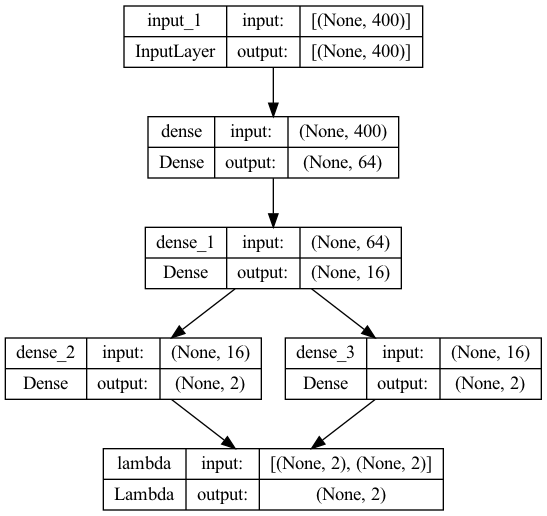

In [10]:
keras.utils.plot_model(encoder, to_file='model.png', show_shapes=True)

In [11]:
vae.fit(input_with_mask,input_with_mask,
        shuffle=True,
        epochs=1000,
        batch_size=32)

Epoch 1/1000
4/4 [==============================] - 0s 2ms/step - loss: 10968.5703
Epoch 2/1000
4/4 [==============================] - 0s 1ms/step - loss: 11150.3477
Epoch 3/1000
4/4 [==============================] - 0s 2ms/step - loss: 9958.7188
Epoch 4/1000
4/4 [==============================] - 0s 2ms/step - loss: 7400.7192
Epoch 5/1000
4/4 [==============================] - 0s 2ms/step - loss: 5071.8374
Epoch 6/1000
4/4 [==============================] - 0s 2ms/step - loss: 3317.3198
Epoch 7/1000
4/4 [==============================] - 0s 2ms/step - loss: 2380.1157
Epoch 8/1000
4/4 [==============================] - 0s 2ms/step - loss: 1646.7393
Epoch 9/1000
4/4 [==============================] - 0s 2ms/step - loss: 1106.2600
Epoch 10/1000
4/4 [==============================] - 0s 2ms/step - loss: 911.7474
Epoch 11/1000
4/4 [==============================] - 0s 2ms/step - loss: 653.5315
Epoch 12/1000
4/4 [==============================] - 0s 2ms/step - loss: 606.5966
Epoch 13/1000


4/4 [==============================] - 0s 2ms/step - loss: 126.1879
Epoch 101/1000
4/4 [==============================] - 0s 2ms/step - loss: 132.0570
Epoch 102/1000
4/4 [==============================] - 0s 2ms/step - loss: 164.3264
Epoch 103/1000
4/4 [==============================] - 0s 2ms/step - loss: 140.5032
Epoch 104/1000
4/4 [==============================] - 0s 2ms/step - loss: 127.5564
Epoch 105/1000
4/4 [==============================] - 0s 2ms/step - loss: 129.8874
Epoch 106/1000
4/4 [==============================] - 0s 2ms/step - loss: 139.2766
Epoch 107/1000
4/4 [==============================] - 0s 2ms/step - loss: 112.6194
Epoch 108/1000
4/4 [==============================] - 0s 2ms/step - loss: 118.3025
Epoch 109/1000
4/4 [==============================] - 0s 1ms/step - loss: 124.0368
Epoch 110/1000
4/4 [==============================] - 0s 2ms/step - loss: 127.7663
Epoch 111/1000
4/4 [==============================] - 0s 1ms/step - loss: 123.7359
Epoch 112/1000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 111.2902
Epoch 200/1000
4/4 [==============================] - 0s 1ms/step - loss: 96.1628
Epoch 201/1000
4/4 [==============================] - 0s 2ms/step - loss: 95.0380
Epoch 202/1000
4/4 [==============================] - 0s 1ms/step - loss: 102.0241
Epoch 203/1000
4/4 [==============================] - 0s 2ms/step - loss: 94.0327
Epoch 204/1000
4/4 [==============================] - 0s 2ms/step - loss: 97.3264
Epoch 205/1000
4/4 [==============================] - 0s 2ms/step - loss: 85.6541
Epoch 206/1000
4/4 [==============================] - 0s 1ms/step - loss: 93.9825
Epoch 207/1000
4/4 [==============================] - 0s 1ms/step - loss: 88.2350
Epoch 208/1000
4/4 [==============================] - 0s 1ms/step - loss: 84.2160
Epoch 209/1000
4/4 [==============================] - 0s 1ms/step - loss: 89.9108
Epoch 210/1000
4/4 [==============================] - 0s 2ms/step - loss: 78.9287
Epoch 211/1000
4/4 [=========

4/4 [==============================] - 0s 2ms/step - loss: 75.7367
Epoch 299/1000
4/4 [==============================] - 0s 2ms/step - loss: 73.3781
Epoch 300/1000
4/4 [==============================] - 0s 2ms/step - loss: 70.6733
Epoch 301/1000
4/4 [==============================] - 0s 2ms/step - loss: 67.0727
Epoch 302/1000
4/4 [==============================] - 0s 1ms/step - loss: 70.6226
Epoch 303/1000
4/4 [==============================] - 0s 1ms/step - loss: 68.3465
Epoch 304/1000
4/4 [==============================] - 0s 2ms/step - loss: 76.8374
Epoch 305/1000
4/4 [==============================] - 0s 1ms/step - loss: 71.6682
Epoch 306/1000
4/4 [==============================] - 0s 1ms/step - loss: 71.5778
Epoch 307/1000
4/4 [==============================] - 0s 1ms/step - loss: 68.7401
Epoch 308/1000
4/4 [==============================] - 0s 2ms/step - loss: 70.5193
Epoch 309/1000
4/4 [==============================] - 0s 2ms/step - loss: 63.5146
Epoch 310/1000
4/4 [===========

4/4 [==============================] - 0s 1ms/step - loss: 125.6464
Epoch 399/1000
4/4 [==============================] - 0s 2ms/step - loss: 113.0508
Epoch 400/1000
4/4 [==============================] - 0s 2ms/step - loss: 88.4165
Epoch 401/1000
4/4 [==============================] - 0s 2ms/step - loss: 89.8214
Epoch 402/1000
4/4 [==============================] - 0s 2ms/step - loss: 123.5909
Epoch 403/1000
4/4 [==============================] - 0s 2ms/step - loss: 105.0249
Epoch 404/1000
4/4 [==============================] - 0s 2ms/step - loss: 102.8231
Epoch 405/1000
4/4 [==============================] - 0s 2ms/step - loss: 104.8896
Epoch 406/1000
4/4 [==============================] - 0s 2ms/step - loss: 101.9630
Epoch 407/1000
4/4 [==============================] - 0s 2ms/step - loss: 70.4545
Epoch 408/1000
4/4 [==============================] - 0s 2ms/step - loss: 81.8081
Epoch 409/1000
4/4 [==============================] - 0s 2ms/step - loss: 77.1201
Epoch 410/1000
4/4 [====

4/4 [==============================] - 0s 1ms/step - loss: 54.0848
Epoch 499/1000
4/4 [==============================] - 0s 2ms/step - loss: 55.9590
Epoch 500/1000
4/4 [==============================] - 0s 2ms/step - loss: 64.0553
Epoch 501/1000
4/4 [==============================] - 0s 1ms/step - loss: 56.2706
Epoch 502/1000
4/4 [==============================] - 0s 2ms/step - loss: 58.9902
Epoch 503/1000
4/4 [==============================] - 0s 1ms/step - loss: 53.1389
Epoch 504/1000
4/4 [==============================] - 0s 2ms/step - loss: 57.6164
Epoch 505/1000
4/4 [==============================] - 0s 2ms/step - loss: 61.2722
Epoch 506/1000
4/4 [==============================] - 0s 2ms/step - loss: 61.7805
Epoch 507/1000
4/4 [==============================] - 0s 2ms/step - loss: 59.6363
Epoch 508/1000
4/4 [==============================] - 0s 2ms/step - loss: 57.6578
Epoch 509/1000
4/4 [==============================] - 0s 2ms/step - loss: 56.9737
Epoch 510/1000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 62.0643
Epoch 599/1000
4/4 [==============================] - 0s 2ms/step - loss: 56.2911
Epoch 600/1000
4/4 [==============================] - 0s 1ms/step - loss: 56.4565
Epoch 601/1000
4/4 [==============================] - 0s 2ms/step - loss: 57.6421
Epoch 602/1000
4/4 [==============================] - 0s 2ms/step - loss: 56.1124
Epoch 603/1000
4/4 [==============================] - 0s 1ms/step - loss: 58.0983
Epoch 604/1000
4/4 [==============================] - 0s 2ms/step - loss: 56.6883
Epoch 605/1000
4/4 [==============================] - 0s 1ms/step - loss: 52.5988
Epoch 606/1000
4/4 [==============================] - 0s 1ms/step - loss: 58.5828
Epoch 607/1000
4/4 [==============================] - 0s 2ms/step - loss: 54.7730
Epoch 608/1000
4/4 [==============================] - 0s 1ms/step - loss: 56.2704
Epoch 609/1000
4/4 [==============================] - 0s 2ms/step - loss: 54.6843
Epoch 610/1000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 56.5935
Epoch 699/1000
4/4 [==============================] - 0s 2ms/step - loss: 52.9805
Epoch 700/1000
4/4 [==============================] - 0s 2ms/step - loss: 53.0761
Epoch 701/1000
4/4 [==============================] - 0s 2ms/step - loss: 64.0954
Epoch 702/1000
4/4 [==============================] - 0s 2ms/step - loss: 60.4644
Epoch 703/1000
4/4 [==============================] - 0s 2ms/step - loss: 58.5452
Epoch 704/1000
4/4 [==============================] - 0s 2ms/step - loss: 55.4906
Epoch 705/1000
4/4 [==============================] - 0s 2ms/step - loss: 66.4333
Epoch 706/1000
4/4 [==============================] - 0s 2ms/step - loss: 53.1333
Epoch 707/1000
4/4 [==============================] - 0s 2ms/step - loss: 60.3752
Epoch 708/1000
4/4 [==============================] - 0s 2ms/step - loss: 65.4025
Epoch 709/1000
4/4 [==============================] - 0s 2ms/step - loss: 69.8958
Epoch 710/1000
4/4 [===========

4/4 [==============================] - 0s 1ms/step - loss: 55.3568
Epoch 799/1000
4/4 [==============================] - 0s 2ms/step - loss: 58.2758
Epoch 800/1000
4/4 [==============================] - 0s 2ms/step - loss: 59.0809
Epoch 801/1000
4/4 [==============================] - 0s 1ms/step - loss: 54.3840
Epoch 802/1000
4/4 [==============================] - 0s 1ms/step - loss: 54.9574
Epoch 803/1000
4/4 [==============================] - 0s 2ms/step - loss: 72.4668
Epoch 804/1000
4/4 [==============================] - 0s 2ms/step - loss: 72.1395
Epoch 805/1000
4/4 [==============================] - 0s 2ms/step - loss: 66.4804
Epoch 806/1000
4/4 [==============================] - 0s 2ms/step - loss: 75.4737
Epoch 807/1000
4/4 [==============================] - 0s 2ms/step - loss: 67.6999
Epoch 808/1000
4/4 [==============================] - 0s 1ms/step - loss: 59.5962
Epoch 809/1000
4/4 [==============================] - 0s 2ms/step - loss: 61.9353
Epoch 810/1000
4/4 [===========

4/4 [==============================] - 0s 1ms/step - loss: 52.5065
Epoch 899/1000
4/4 [==============================] - 0s 2ms/step - loss: 56.8318
Epoch 900/1000
4/4 [==============================] - 0s 1ms/step - loss: 49.4099
Epoch 901/1000
4/4 [==============================] - 0s 2ms/step - loss: 54.1582
Epoch 902/1000
4/4 [==============================] - 0s 2ms/step - loss: 48.6539
Epoch 903/1000
4/4 [==============================] - 0s 2ms/step - loss: 55.7743
Epoch 904/1000
4/4 [==============================] - 0s 2ms/step - loss: 46.9409
Epoch 905/1000
4/4 [==============================] - 0s 1ms/step - loss: 46.4683
Epoch 906/1000
4/4 [==============================] - 0s 2ms/step - loss: 49.1946
Epoch 907/1000
4/4 [==============================] - 0s 2ms/step - loss: 51.1547
Epoch 908/1000
4/4 [==============================] - 0s 2ms/step - loss: 47.1966
Epoch 909/1000
4/4 [==============================] - 0s 1ms/step - loss: 61.1780
Epoch 910/1000
4/4 [===========

4/4 [==============================] - 0s 1ms/step - loss: 52.9584
Epoch 999/1000
4/4 [==============================] - 0s 1ms/step - loss: 56.2460
Epoch 1000/1000
4/4 [==============================] - 0s 2ms/step - loss: 52.5568


In [ ]:
from sklearn.metrics import mean_squared_error
Y = vae.predict(input_with_mask)
imputed = pd.DataFrame(Y)

# generate boolean mask for missing values
masked = df2.isnull()

# convert True values to index positions
missing_indexes = np.where(masked)

imputed_values = imputed.iloc[missing_indexes].values.flatten()
orignal_values = original.iloc[missing_indexes].values.flatten()

corr = np.corrcoef(orignal_values, imputed_values)[0, 1]
mse = np.mean((orignal_values - imputed_values) ** 2) / np.var(orignal_values)
print("Correlation coefficient:", corr)
print("Normalized Mean Squared Error:", mse)

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

Y = vae.predict(input_with_mask)

imputed = pd.DataFrame(Y)
scaler = StandardScaler()
z_scores = pd.DataFrame(scaler.fit_transform(imputed))
scaler2 = StandardScaler()
original2 = pd.DataFrame(scaler2.fit_transform(original.T))


# generate boolean mask for missing values
masked = df2.T.isnull()

# convert True values to index positions
missing_indexes = np.where(masked)

imputed_values = z_scores.iloc[missing_indexes].values.flatten()
orignal_values = original2.iloc[missing_indexes].values.flatten()

corr = np.corrcoef(orignal_values, imputed_values)[0, 1]
mse = np.mean((orignal_values - imputed_values) ** 2) / np.var(orignal_values)
print("Correlation coefficient:", corr)
print("Normalized Mean Squared Error:", mse)

4/4 [==============================] - 0s 856us/step
Correlation coefficient: 0.9824878554732388
Normalized Mean Squared Error: 0.03502428904745822


4/4 [==============================] - 0s 902us/step


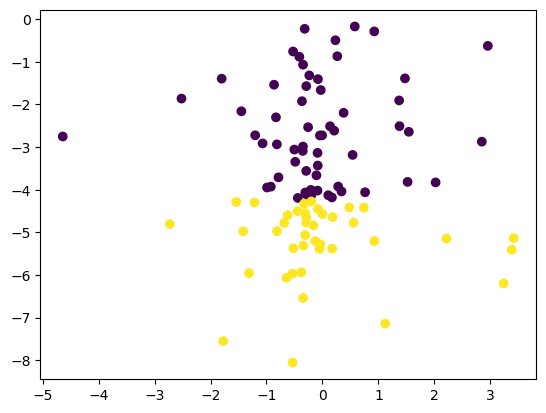

In [13]:
embedding = encoder.predict(input_with_mask)[0]
plt.scatter(embedding[:, 0], embedding[:, 1], c=gene_y)
plt.show()


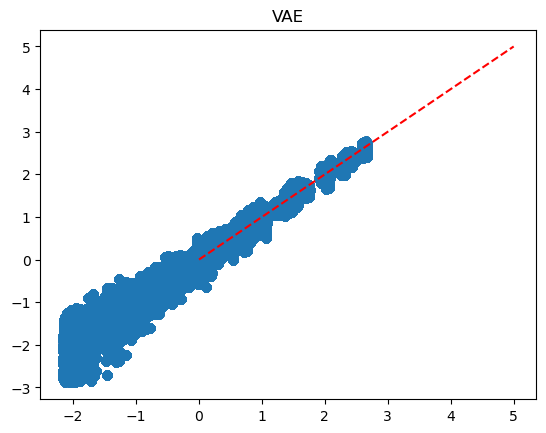

In [15]:
plt.scatter(imputed_values, orignal_values)
plt.plot([0, 5], [0, 5], color='red', linestyle='--')
plt.title('VAE')
plt.show()

# Scaled Data

In [ ]:
# Read the Data
#df = pd.read_csv('../../data/original.csv',  index_col=0)
scaled = pd.read_csv('../../data/mcar_scaled.csv',  index_col=0)
scaled = np.array(scaled)  
n_dims = scaled.shape[1]

In [ ]:
mask = np.array(bool_to_binary(create_missing_mask(scaled)))
X_no_na = replace_nan(scaled, replacement = 1)
scaled_with_mask = np.hstack([X_no_na, mask])


In [ ]:
vae.fit(scaled_with_mask,scaled_with_mask,
        epochs=500,
        batch_size=16)

In [ ]:
embedding = encoder.predict(input_with_mask)[0]
plt.scatter(embedding[:, 0], embedding[:, 1], c=y)
plt.show()